<a href="https://colab.research.google.com/github/amank56/Stock-prediction/blob/master/Stock_pridict_bidirectional_attention_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence , text
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving apple_data.csv to apple_data.csv


In [0]:
import io

ds0 = pd.read_csv(io.BytesIO(uploaded['apple_data.csv']))
#ds0 = pd.read_csv(io.BytesIO(uploaded['sector_Combine_tech.csv']))
#ds1 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-26-2020.csv']))
#ds2 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-28-2020.csv']))
#ds3 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-29-2020.csv']))
#ds4 = pd.read_csv(io.BytesIO(uploaded['Ds_Apple_04-30-2020.csv']))
df=ds0
#frames=[ds0,ds1,ds2,ds3,ds4]
#df=pd.concat(frames)
#df= pd.read_csv("/content/Ds_Apple.csv")

In [4]:
df.head()

,Unnamed: 0,Firm,Date,Headlines,Label,Description,Open,Close
0,0,Apple,03-19-2012,How to Play It: A dividend strategy with Apple...,1,Apple isn't the only prominent company that an...,85.48143,85.871429
1,1,Apple,03-19-2012,How to Play It: A dividend strategy with Apple...,1,Apple isn't the only\nprominent company that a...,85.48143,85.871429
2,2,Apple,03-19-2012,UPDATE 6-Apple's Cook finally shares $98 billi...,1,"Apple Inc CEO\nTim Cook, moving swiftly after ...",85.48143,85.871429
3,3,Apple,03-19-2012,RPT-US STOCKS-S&P within 10 pct of record high...,1,The S&P 500 extended its\nrally on Monday to c...,85.48143,85.871429
4,4,Apple,03-19-2012,S&P within 10 pct of record high; Apple up on ...,1,The S&P 500 extended its\nrally on Monday to c...,85.48143,85.871429


In [0]:
#processing the text of headline/Description

col_name='Headlines'
# Remove all the special characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\W+', ' ', x))

# remove all single characters
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',x))

# Remove single characters from the start
df[col_name]=df[col_name].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',x))

#Substituting multiple spaces with single space
df[col_name]=df[col_name].map(lambda x: re.sub(r'\s+', ' ',x,flags=re.I))

# Removing prefixed 'b'
df[col_name]=df[col_name].map(lambda x: re.sub(r'^b\s+', ' ',x))

Understand the distribution better.


Text(0.5, 1.0, 'Number of +ive and -ive messages - 0 is -ve and +ive is 1')

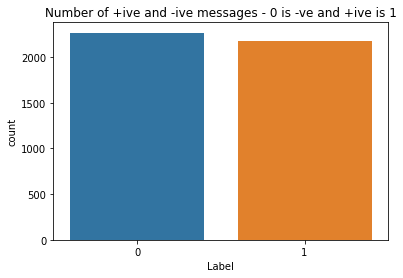

In [6]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of +ive and -ive messages - 0 is -ve and +ive is 1')

1. Create input and output vectors.

2. Process the labels.

In [0]:
X = df.Headlines
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

**Process the data**

Tokenize the data and convert the text to sequences.

Add padding to ensure that all the sequences have the same shape.

There are many ways of taking the max_len and here an arbitrary length of 150 is chosen

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

**RNN**

Define the RNN structure.

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [12]:
#without Early stopping
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3020 samples, validate on 756 samples
Epoch 1/10
3020/3020 [==============================] - 11s 4ms/step - loss: 0.6933 - accuracy: 0.5046 - val_loss: 0.6913 - val_accuracy: 0.5926
Epoch 2/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.6756 - accuracy: 0.6106 - val_loss: 0.6618 - val_accuracy: 0.5952
Epoch 3/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.6055 - accuracy: 0.6821 - val_loss: 0.6346 - val_accuracy: 0.6204
Epoch 4/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.5342 - accuracy: 0.7377 - val_loss: 0.6419 - val_accuracy: 0.6627
Epoch 5/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.4914 - accuracy: 0.7656 - val_loss: 0.6268 - val_accuracy: 0.6693
Epoch 6/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.4532 - accuracy: 0.7974 - val_loss: 0.6337 - val_accuracy: 0.6852
Epoch 7/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.4275 - acc

In [13]:
#with early stopping
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3020 samples, validate on 756 samples
Epoch 1/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.3237 - accuracy: 0.8649 - val_loss: 0.6970 - val_accuracy: 0.7262
Epoch 2/10
3020/3020 [==============================] - 9s 3ms/step - loss: 0.2984 - accuracy: 0.8788 - val_loss: 0.7727 - val_accuracy: 0.7275


Process the test set data.

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [15]:
accr = model.evaluate(test_sequences_matrix,Y_test)

667/667 [==============================] - 1s 913us/step


In [16]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.773
  Accuracy: 0.714


**Bidirectional LSTM**

In [0]:
def BiDirRNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Model Summary


In [18]:
bimodel = BiDirRNN()
bimodel.summary()
bimodel.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [19]:
#without early stopping
history=bimodel.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

#with early stopping 
#history=bimodel.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3020 samples, validate on 756 samples
Epoch 1/10
3020/3020 [==============================] - 18s 6ms/step - loss: 0.6935 - accuracy: 0.5033 - val_loss: 0.6927 - val_accuracy: 0.4788
Epoch 2/10
3020/3020 [==============================] - 17s 6ms/step - loss: 0.6803 - accuracy: 0.5960 - val_loss: 0.6714 - val_accuracy: 0.5899
Epoch 3/10
3020/3020 [==============================] - 17s 6ms/step - loss: 0.6046 - accuracy: 0.6798 - val_loss: 0.6342 - val_accuracy: 0.6389
Epoch 4/10
3020/3020 [==============================] - 17s 6ms/step - loss: 0.5320 - accuracy: 0.7288 - val_loss: 0.6291 - val_accuracy: 0.6574
Epoch 5/10
3020/3020 [==============================] - 17s 5ms/step - loss: 0.4907 - accuracy: 0.7692 - val_loss: 0.6280 - val_accuracy: 0.6706
Epoch 6/10
3020/3020 [==============================] - 17s 6ms/step - loss: 0.4537 - accuracy: 0.7861 - val_loss: 0.6459 - val_accuracy: 0.6918
Epoch 7/10
3020/3020 [==============================] - 17s 6ms/step - loss: 0.4254

Evaluate the model on the test set.

In [20]:
accr_bi = bimodel.evaluate(test_sequences_matrix,Y_test)

667/667 [==============================] - 1s 2ms/step


In [21]:
print('Bidirectional LSTM - Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_bi[0],accr_bi[1]))

Bidirectional LSTM - Test set
  Loss: 0.710
  Accuracy: 0.682


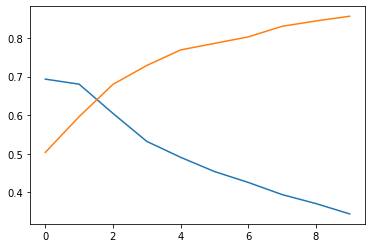

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

**Bidirectional LSTM and Attention**


In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
       
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
def make_df(max_features, maxlen):    
    tokenizer = text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train))
    list_tokenized_train = tokenizer.texts_to_sequences(X_train)
    list_tokenized_test = tokenizer.texts_to_sequences(X_test)
    X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
    X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

    word_index = tokenizer.word_index

    return X_t, X_te, word_index

In [0]:
def make_glovevec(glovepath, max_features, embed_size, word_index, veclen=300):
    embeddings_index = {}
    f = open(glovepath)
    for line in f:
        values = line.split()
        word = ' '.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs.reshape(-1)
    f.close()

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def BidLstm(maxlen, max_features, embed_size, embedding_matrix):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,
                           recurrent_dropout=0.25))(x)
    x = Attention(maxlen)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)

    return model

In [0]:
 max_features = 1000
 maxlen = 150
 embed_size = 300

 xtr, xte, word_index = make_df( max_features, maxlen)
 embedding_vector = make_glovevec("/content/drive/My Drive/MLData/glove.42B.300d.txt",
                                     max_features, embed_size, word_index)
 

In [27]:
model = BidLstm(maxlen, max_features, embed_size, embedding_vector)
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 600)          1442400   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               750       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               153856    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257 

In [28]:
#without early stopping
historyBiDirAttn=model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Train on 3020 samples, validate on 756 samples
Epoch 1/10
3020/3020 [==============================] - 20s 6ms/step - loss: 0.6941 - accuracy: 0.4950 - val_loss: 0.6924 - val_accuracy: 0.5212
Epoch 2/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6954 - accuracy: 0.4983 - val_loss: 0.6915 - val_accuracy: 0.5212
Epoch 3/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6953 - accuracy: 0.5156 - val_loss: 0.6929 - val_accuracy: 0.5013
Epoch 4/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6967 - accuracy: 0.5099 - val_loss: 0.6920 - val_accuracy: 0.5212
Epoch 5/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6919 - accuracy: 0.5215 - val_loss: 0.6888 - val_accuracy: 0.5463
Epoch 6/10
3020/3020 [==============================] - 18s 6ms/step - loss: 0.7092 - accuracy: 0.5623 - val_loss: 0.6818 - val_accuracy: 0.5437
Epoch 7/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6797

667/667 [==============================] - 1s 2ms/step
Bidirectional LSTM Attn 1- Test set
  Loss: 0.734
  Accuracy: 0.534


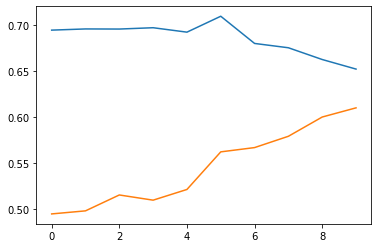

In [29]:
accr_bi = model.evaluate(test_sequences_matrix,Y_test)
print('Bidirectional LSTM Attn 1- Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_bi[0],accr_bi[1]))
plt.plot(historyBiDirAttn.history['loss'])
plt.plot(historyBiDirAttn.history['accuracy'])

In [0]:
def BiDirRNNWithAttention(maxlen, max_features, embed_size, embedding_matrix):   
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.35,
                           recurrent_dropout=0.35))(x)
    x = Attention(maxlen)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.50)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)   
    return model

In [32]:
Atnmodel2 = BiDirRNNWithAttention(maxlen, max_features, embed_size, embedding_vector)
Atnmodel2.summary()
Atnmodel2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 400)          801600    
_________________________________________________________________
attention_2 (Attention)      (None, 400)               550       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               102656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257 

In [33]:
#without early stopping
historyBiDirAttn2=Atnmodel2.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Train on 3020 samples, validate on 756 samples
Epoch 1/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6936 - accuracy: 0.5119 - val_loss: 0.6920 - val_accuracy: 0.5212
Epoch 2/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6937 - accuracy: 0.4964 - val_loss: 0.6943 - val_accuracy: 0.4802
Epoch 3/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6919 - accuracy: 0.5311 - val_loss: 0.6874 - val_accuracy: 0.5265
Epoch 4/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6848 - accuracy: 0.5613 - val_loss: 0.6821 - val_accuracy: 0.5357
Epoch 5/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6793 - accuracy: 0.5712 - val_loss: 0.6872 - val_accuracy: 0.5542
Epoch 6/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6707 - accuracy: 0.5851 - val_loss: 0.6747 - val_accuracy: 0.5608
Epoch 7/10
3020/3020 [==============================] - 19s 6ms/step - loss: 0.6600

667/667 [==============================] - 1s 2ms/step
Bidirectional LSTM attn 2- Test set
  Loss: 0.669
  Accuracy: 0.576


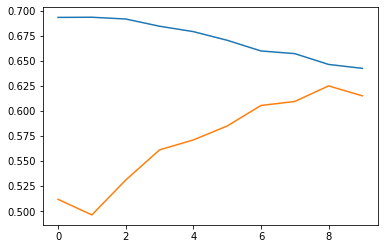

In [34]:
accr_bi2 = Atnmodel2.evaluate(test_sequences_matrix,Y_test)
print('Bidirectional LSTM attn 2- Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_bi2[0],accr_bi2[1]))
plt.plot(historyBiDirAttn2.history['loss'])
plt.plot(historyBiDirAttn2.history['accuracy'])

In [36]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2020-05-09 03:09:00--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2020-05-09 03:09:00--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2020-05-09 03:09:00--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [50]:
!unzip glove*.zip -d '/content/drive/My Drive/MLData/'

Archive:  glove.42B.300d.zip
  inflating: /content/drive/My Drive/MLData/glove.42B.300d.txt  


In [71]:
from shutil import copyfile
copyfile('/content/drive/My Drive/MLData/glove.42B.300d.txt', '/content/glove.42B.300d.txt')

'/content/glove.42B.300d.txt'

In [49]:
!ls
!pwd

adc.json  drive  glove.42B.300d.zip  sample_data  sector_Combine_tech.csv
/content


In [41]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('/content/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 1917494 word vectors.


In [47]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/content')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1T25rZ8rWYe7quLGa4XBUsrwaFZzR1FBt' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  print(f.read())

title: glove.42B.300d.txt, id: 1S3m64BVd08taxnVEcnCYqDuQDdS6abcD
downloading to /root/content/glove.42B.300d.txt


KeyboardInterrupt: ignored

In [43]:
#!pip install --upgrade pip
!pip install -U -q pydrive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

     |████████████████████████████████| 1.5MB 2.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following

In [1]:
with io.open('/content/glove.42B.300d.txt', encoding='utf8') as f:
  head = [next(f) for x in range(5)]
  print(head)

NameError: ignored

In [46]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('https://drive.google.com/drive/folders/MLdata', 'wb'))

FileNotFoundError: ignored

In [35]:
bimodelAttn = BiDirRNNWithAttention()
bimodelAttn.summary()
bimodelAttn.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

TypeError: ignored